## Using Groupings Created by PreSupposed Algorithms

## Starting environement

Loaded model from ./models/31st.zip
Episode finished after 990 steps
Trees placed at: [(np.int64(58), np.int64(42)), (np.int64(86), np.int64(46)), (np.int64(90), np.int64(18))]
Shrubs placed at: [(np.int64(6), np.int64(38)), (np.int64(6), np.int64(50)), (np.int64(6), np.int64(62)), (np.int64(12), np.int64(72)), (np.int64(16), np.int64(38)), (np.int64(16), np.int64(48)), (np.int64(16), np.int64(58)), (np.int64(22), np.int64(66)), (np.int64(24), np.int64(76)), (np.int64(26), np.int64(40)), (np.int64(32), np.int64(62)), (np.int64(34), np.int64(46)), (np.int64(34), np.int64(74)), (np.int64(36), np.int64(34)), (np.int64(40), np.int64(54)), (np.int64(42), np.int64(64)), (np.int64(44), np.int64(40)), (np.int64(46), np.int64(26)), (np.int64(49), np.int64(49)), (np.int64(52), np.int64(34)), (np.int64(52), np.int64(60)), (np.int64(60), np.int64(52)), (np.int64(62), np.int64(30)), (np.int64(64), np.int64(12)), (np.int64(68), np.int64(38)), (np.int64(68), np.int64(60)), (np.int64(70), np.int64(48)

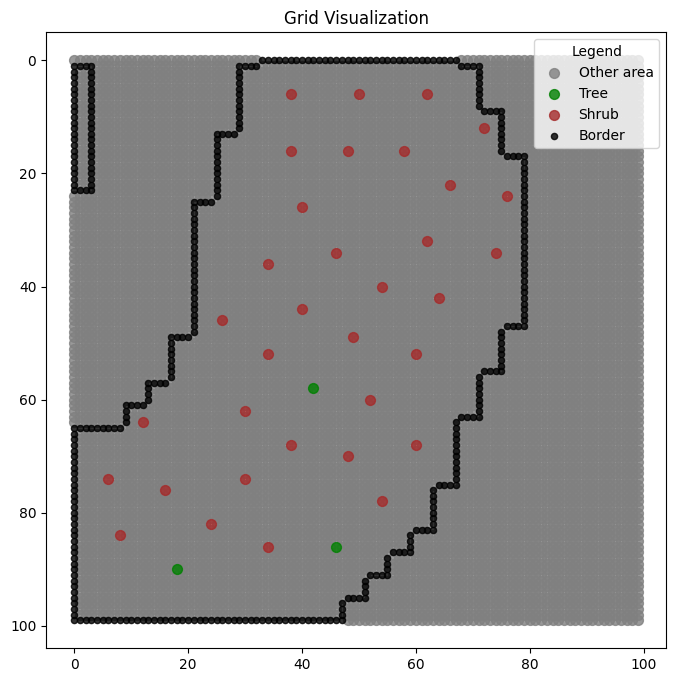

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors
import os

# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w, h) of grid, defaults to (100, 100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.max_attempts = 100000  # Maximum number of attempts
        self.attempt_counter = 0  # Tracks the number of attempts

        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Plants: 1 for Tree, 2 for Shrub, 0 for No plant (added)
        self.plants = np.array([0, 1, 2])  # [No Plant, Tree, Shrub]

        # Action space: Use Box for percentage (horizontal, vertical) and plant type (no object, shrub, tree)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # Observation space: Dict containing the grid and distances (both horizontal and vertical)
        self.observation_space = spaces.Dict({
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Vertical distance (top)
            "tree_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of trees
            "shrub_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of shrubs
            "good_tree_spot": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Whether the spot is good for planting a tree
            "border_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  
        })

        self.num_trees = 0
        self.num_shrubs = 0
        self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        tree_proportion = np.array([0.0], dtype=np.float32)
        shrub_proportion = np.array([0.0], dtype=np.float32)
        good_tree_spot = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)
        border_score = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)

        # Initial observation
        return {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1), now including No Plant.
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = 0  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.33:
            plant_type = 0  # No Plant (new option)
        elif plant_type_selector < 0.66:
            plant_type = 1  # Tree
        else:
            plant_type = 2  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            if len(self.distances) > 0:  # Ensure there are distances to access
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            ####################################################################################
            ### Shrub Proportion and Tree proportion and reward mechanism
            #  Calculate tree and shrub proportions
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0
            balance_reward = 0

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions
                if tree_proportion > 0.2:
                    balance_reward += 2

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1
                if shrub_proportion > 0.6:
                    balance_reward += 1

            ####################################################################################
            ### Good Tree Spot and Distance mechanism
            good_tree_spot = 1.0  # Assume the spot is good initially
            if plant_type == 1:  # Only check for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):
                        continue
                    # Calculate the distance between the planted tree and all other trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # If any tree is within 50 units, it's not a good spot
                        good_tree_spot = 0.0
                        break
            distance_reward = 0.5
            # Only apply reward for trees (plant_type == 1)
            if self.plants[plant_type] == 1:
                # Apply a reward based on how far the nearest tree is, capped at 50 units
                if good_tree_spot == 1.0:
                    distance_reward = 1  # Normalize reward (closer to 50 = higher reward)
                else:
                    distance_reward = 0

            ####################################################################################

            ### Border Score Segment

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            border_score = 0
            if (abs(horizontal_distance - 0.5) + abs(vertical_distance - 0.5)) > 0.8:
                border_score = 1

            ####################################################################################

            ### Total reward Segment
            reward = 3 * balance_reward + 2 *distance_reward + border_score
            ####################################################################################

            if plant_type == 0:
            # No planting is done, but a small positive reward could be given to avoid excessive no-action use
                reward = 1

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action
            tree_proportion = self.num_trees / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            shrub_proportion = self.num_shrubs / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            good_tree_spot = 0.0

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)
        tree_proportion = np.array([tree_proportion], dtype=np.float32)
        shrub_proportion = np.array([shrub_proportion], dtype=np.float32)
        good_tree_spot = np.array([good_tree_spot], dtype=np.float32)
        border_score = np.array([border_score], dtype=np.float32)

        # Observation: the current state of the environment (grid, distances, and tree/shrub proportions)
        observation = {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy

    
    
import matplotlib.patches as mpatches
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=100000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        # print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model

def load_pretrained_model(model_path):
    """
    Load a pretrained PPO model from a specified path.
    """
    if not os.path.exists(model_path):
        raise ValueError(f"Model path {model_path} does not exist.")
    
    model = PPO.load(model_path)
    print(f"Loaded model from {model_path}")
    return model


def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.
    """
    obs, _ = env.reset()
    step = 0

    while True:
        action, _states = model.predict(obs, deterministic=False)
        noise = np.random.normal(0, 0.05, size=action.shape)
        randomized_action = np.clip(action + noise, 0, 1)
        obs, reward, terminated, truncated, info = env.step(randomized_action)
        
        step += 1

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return env.grid  # Only return the grid


def extract_tree_shrub_placements(grid):
    """
    Extracts the tree and shrub placements from the final grid.
    
    Args:
        grid (np.ndarray): The final grid after placement.
    
    Returns:
        trees (list of tuple): List of coordinates of tree placements.
        shrubs (list of tuple): List of coordinates of shrub placements.
    """
    trees = list(zip(*np.where(grid == 1)))
    shrubs = list(zip(*np.where(grid == 2)))
    return trees, shrubs


# Main function to load model and generate new placement
def main(model_path):
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
    model = load_pretrained_model(model_path)
    final_grid = generate_new_placement(env, model)
    return final_grid


# Visualization (optional, for debugging)
def visualize_grid_with_circles(grid):
    plt.figure(figsize=(8, 8))
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},
        1: {'color': 'green', 'label': 'Tree', 'size': 50},
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},
        255: {'color': 'black', 'label': 'Border', 'size': 20},
    }

    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=style['size'], alpha=0.8)

    plt.gca().invert_yaxis()
    plt.legend(title="Legend", loc='upper right')
    plt.title("Grid Visualization")
    plt.grid(False)
    plt.show()


if __name__ == "__main__":
    # Specify the path to the pretrained model directory
    model_path = "./models/31st.zip"
    final_grid = main(model_path)
    trees, shrubs = extract_tree_shrub_placements(final_grid)
    print("Trees placed at:", trees)
    print("Shrubs placed at:", shrubs)

    # Optional visualization
    visualize_grid_with_circles(final_grid)


## Grouping them by distance

Loaded model from ./models/31st.zip
Episode finished after 396 steps


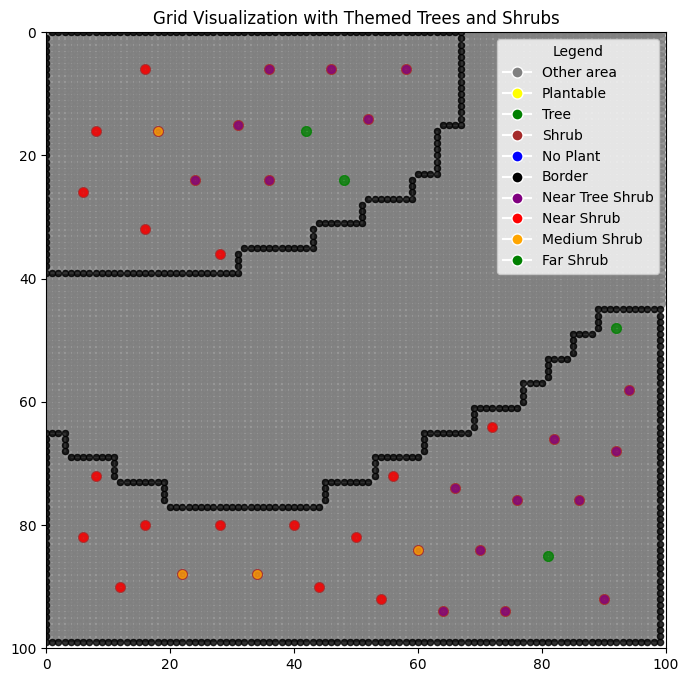

In [3]:
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import numpy as np

def calculate_distance_to_border(grid, border_value=255):
    """
    Calculate the Euclidean distance from each plot to the nearest border.

    Args:
        grid (np.ndarray): The grid with shrub placements and borders.
        border_value (int): The pixel value in the grid representing the border.

    Returns:
        distance_map (np.ndarray): The distance of each point to the nearest border.
    """
    border_mask = (grid == border_value).astype(int)
    distance_map = distance_transform_edt(1 - border_mask)  # Invert mask so distance is from border pixels
    return distance_map

def calculate_distance_to_tree(grid, tree_value=1):
    """
    Calculate the Euclidean distance from each plot to the nearest tree.

    Args:
        grid (np.ndarray): The grid with shrub placements and trees.
        tree_value (int): Value in the grid representing trees.

    Returns:
        distance_map (np.ndarray): The distance of each point to the nearest tree.
    """
    tree_mask = (grid == tree_value).astype(int)
    distance_map = distance_transform_edt(1 - tree_mask)  # Invert mask so distance is from tree pixels
    return distance_map

def categorize_shrubs_by_distance(grid, border_distance_map, tree_distance_map, shrub_value=2, near_tree_thresh=20, near_thresh=10, far_thresh=50):
    """
    Categorize shrubs based on their distance to the nearest border or tree.

    Args:
        grid (np.ndarray): The grid with shrub placements.
        border_distance_map (np.ndarray): The distance of each point to the nearest border.
        tree_distance_map (np.ndarray): The distance of each point to the nearest tree.
        shrub_value (int): Value in the grid representing shrubs.
        near_tree_thresh (float): Threshold distance for "Near Tree" category.
        near_thresh (float): Threshold distance for "Near" category.
        far_thresh (float): Threshold distance for "Far" category.

    Returns:
        clusters (dict): Dictionary with shrub coordinates categorized by distance.
    """
    shrub_coords = np.argwhere(grid == shrub_value)
    clusters = {"Near Tree": [], "Near": [], "Medium": [], "Far": []}

    # Categorize each shrub based on distances
    for coord in shrub_coords:
        tree_distance = tree_distance_map[coord[0], coord[1]]
        border_distance = border_distance_map[coord[0], coord[1]]
        
        if tree_distance <= near_tree_thresh:
            clusters["Near Tree"].append(tuple(coord))
        elif border_distance <= near_thresh:
            clusters["Near"].append(tuple(coord))
        elif border_distance <= far_thresh:
            clusters["Medium"].append(tuple(coord))
        else:
            clusters["Far"].append(tuple(coord))

    return clusters

def visualize_grid_with_circles(grid, clusters=None):
    """
    Visualize the grid with themed markers for different areas and categories of shrubs based on distance.

    Args:
        grid (np.ndarray): The grid with various elements (shrub, tree, etc.).
        clusters (dict): Optional dictionary with shrub coordinates categorized by distance.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles based on your preferences
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},  # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},  # Plantable spots
        1: {'color': 'green', 'label': 'Tree', 'size': 50},  # Tree planted
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},  # Default Shrub color
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},  # No Plant selected
        255: {'color': 'black', 'label': 'Border', 'size': 20},  # Border area
    }

    # Plot each category based on the marker_styles dictionary
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'],
                        label=style['label'], s=style['size'], alpha=0.8)

    # If clusters are provided, override shrub colors based on distance categories
    if clusters:
        cluster_colors = {"Near Tree": "purple", "Near": "red", "Medium": "orange", "Far": "green"}
        for category, color in cluster_colors.items():
            if clusters[category]:  # Only plot if there are coordinates in the category
                y_coords, x_coords = zip(*clusters[category])
                plt.scatter(x_coords, y_coords, color=color, label=f"{category} Shrub ({len(clusters[category])})", s=30, alpha=0.7)

    # Customize the plot further
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style['color'], markersize=8, label=style['label'])
               for style in marker_styles.values()]
    for category, color in cluster_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f"{category} Shrub"))
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.title("Grid Visualization with Themed Trees and Shrubs")
    plt.grid(False)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Assuming final_grid is obtained from the main function
    final_grid = main(model_path)

    # Calculate distance to the nearest border
    border_distance_map = calculate_distance_to_border(final_grid)

    # Calculate distance to the nearest tree
    tree_distance_map = calculate_distance_to_tree(final_grid)

    # Categorize shrubs by their distance to the border and tree proximity
    clusters = categorize_shrubs_by_distance(final_grid, border_distance_map, tree_distance_map)

    # Plot the categorized clusters with theming
    visualize_grid_with_circles(final_grid, clusters)


Loaded model from ./models/31st.zip
Episode finished after 1040 steps


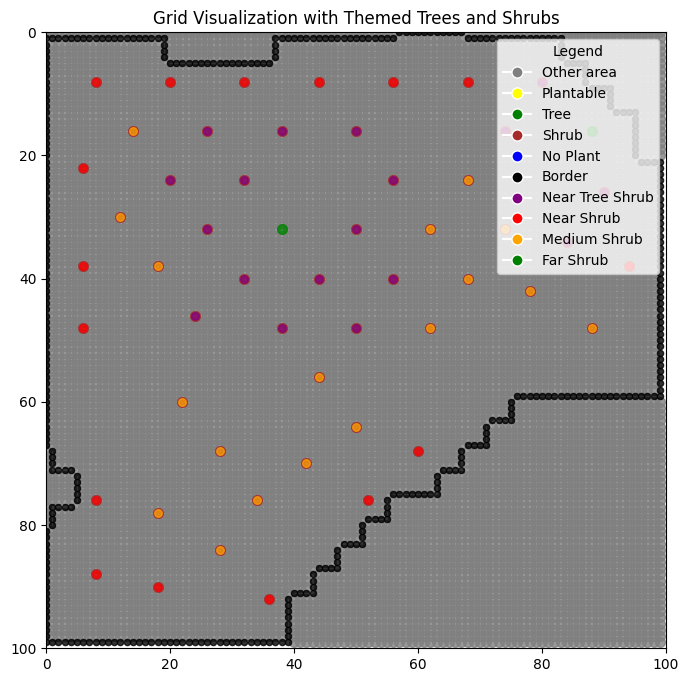

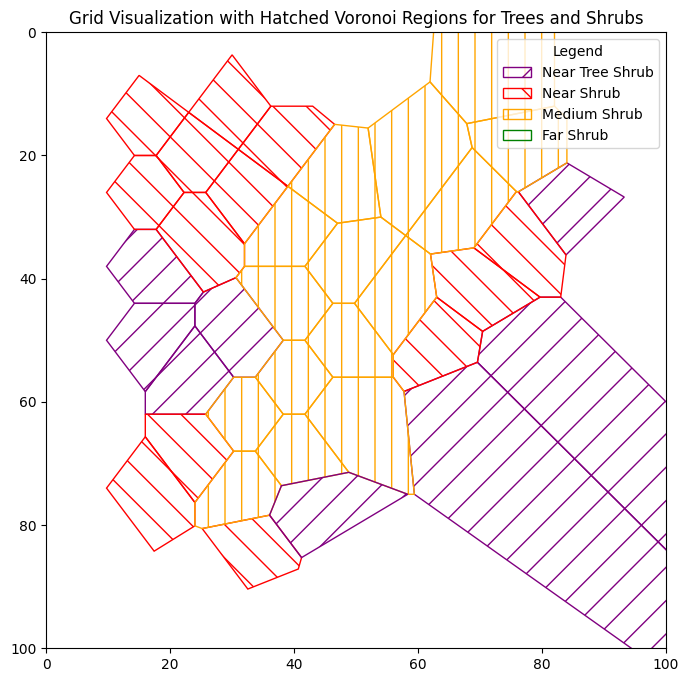

In [14]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def create_voronoi_regions(grid_shape, clusters):
    """
    Create Voronoi regions for shrubs based on their proximity to points.
    Args:
        grid_shape (tuple): The shape of the grid.
        clusters (dict): Dictionary with shrub coordinates categorized by distance.
    Returns:
        vor (Voronoi): Voronoi object for plotting.
        points (list): List of all shrub points with categories.
        categories (list): List of categories corresponding to each point.
    """
    points = []
    categories = []
    for category, coords in clusters.items():
        points.extend(coords)
        categories.extend([category] * len(coords))

    # Create the Voronoi diagram for the shrub points
    vor = Voronoi(points)
    return vor, points, categories

def visualize_voronoi_with_hatching(vor, points, categories, grid_shape):
    """
    Visualize Voronoi regions with hatching patterns according to shrub category.
    Args:
        vor (Voronoi): Voronoi object with shrub-based regions.
        points (list): List of shrub points.
        categories (list): List of categories corresponding to each point.
        grid_shape (tuple): Shape of the grid.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define hatching patterns for each category
    hatching_patterns = {
        "Near Tree": '/',   # Diagonal
        "Near": '\\',       # Back diagonal
        "Medium": '|',      # Vertical lines
        "Far": '-',         # Horizontal lines
    }
    cluster_colors = {"Near Tree": "purple", "Near": "red", "Medium": "orange", "Far": "green"}

    # Plot Voronoi regions with hatching based on categories
    for region_index, region in enumerate(vor.regions):
        if not -1 in region and len(region) > 0:
            polygon = [vor.vertices[i] for i in region]
            category = categories[region_index % len(categories)]
            color = cluster_colors[category]
            hatch = hatching_patterns[category]

            # Draw the polygon with hatching
            poly_patch = patches.Polygon(polygon, closed=True, edgecolor=color, facecolor='none', hatch=hatch)
            ax.add_patch(poly_patch)

    # Customize the plot
    plt.xlim(0, grid_shape[1])
    plt.ylim(0, grid_shape[0])
    plt.gca().invert_yaxis()

    # Corrected Legend setup
    handles = [
        patches.Patch(facecolor='none', edgecolor=cluster_colors[category], hatch=hatching_patterns[category], 
                      label=f"{category} Shrub") for category in cluster_colors.keys()
    ]
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.title("Grid Visualization with Hatched Voronoi Regions for Trees and Shrubs")
    plt.grid(False)
    plt.show()

# Example call to visualize the grid
# visualize_voronoi_with_hatching(vor, points, categories, final_grid.shape)

# Main execution
if __name__ == "__main__":
    # Assuming final_grid is obtained from the main function
    final_grid = main(model_path)

    # Calculate distance to the nearest border and tree (already existing calculations)
    border_distance_map = calculate_distance_to_border(final_grid)
    tree_distance_map = calculate_distance_to_tree(final_grid)

    # Categorize shrubs by their distance to the border and tree proximity
    clusters = categorize_shrubs_by_distance(final_grid, border_distance_map, tree_distance_map)

    # Create Voronoi regions and plot with hatching based on categories
    vor, points, categories = create_voronoi_regions(final_grid.shape, clusters)
    visualize_grid_with_circles(final_grid, clusters)
    visualize_voronoi_with_hatching(vor, points, categories, final_grid.shape)


Loaded model from ./models/31st.zip
Episode finished after 286 steps


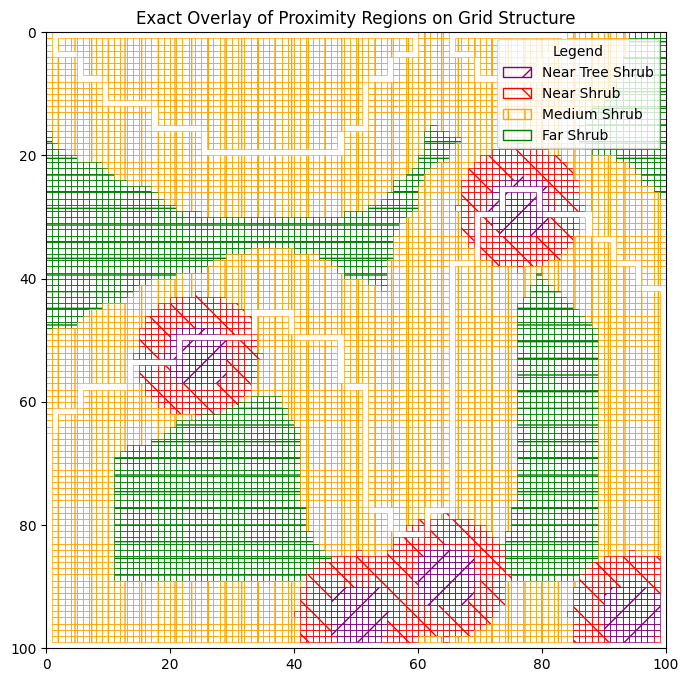

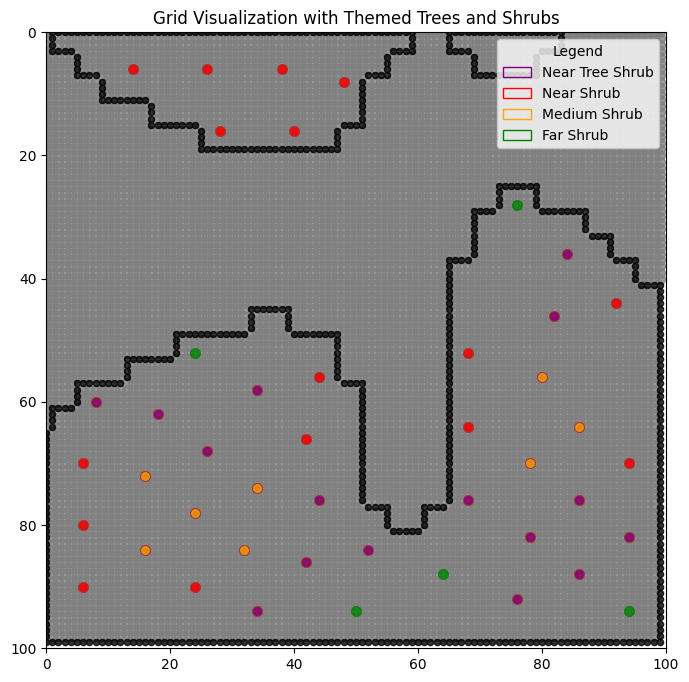

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import distance_transform_edt

def calculate_distance_maps(grid):
    """
    Generate distance maps for borders and trees based on the original grid.

    Args:
        grid (np.ndarray): Original grid from the RL model.

    Returns:
        tuple: Distance maps for border and tree regions.
    """
    border_value = 255  # Assuming border has a value of 255
    tree_value = 1      # Assuming tree has a value of 1
    border_distance_map = distance_transform_edt(grid != border_value)
    tree_distance_map = distance_transform_edt(grid != tree_value)
    return border_distance_map, tree_distance_map

def create_proximity_overlay(grid, border_distance_map, tree_distance_map, distance_threshold=10):
    """
    Overlay proximity categories directly onto the grid, preserving its exact layout.

    Args:
        grid (np.ndarray): Original grid structure.
        border_distance_map (np.ndarray): Distance map for borders.
        tree_distance_map (np.ndarray): Distance map for trees.
        distance_threshold (int): Threshold for categorizing proximity.

    Returns:
        np.ndarray: Grid with proximity categories assigned to cells based on distances.
    """
    proximity_grid = np.full(grid.shape, None, dtype=object)
    
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] == 255:  # Black border cells remain unmodified
                continue

            tree_dist = tree_distance_map[i, j]
            border_dist = border_distance_map[i, j]
            
            if tree_dist <= distance_threshold / 2:
                proximity_grid[i, j] = "Near Tree"
            elif tree_dist <= distance_threshold:
                proximity_grid[i, j] = "Near"
            elif border_dist <= distance_threshold:
                proximity_grid[i, j] = "Medium"
            else:
                proximity_grid[i, j] = "Far"
                
    return proximity_grid

def visualize_exact_overlay(grid, proximity_grid):
    """
    Visualize the exact overlay of proximity regions on the grid structure using hatching.

    Args:
        grid (np.ndarray): Original grid.
        proximity_grid (np.ndarray): Grid with proximity categories overlaid.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define hatching patterns and colors
    hatching_patterns = {
        "Near Tree": '/',   # Diagonal
        "Near": '\\',       # Back diagonal
        "Medium": '|',      # Vertical lines
        "Far": '-',         # Horizontal lines
    }
    cluster_colors = {
        "Near Tree": "purple",
        "Near": "red",
        "Medium": "orange",
        "Far": "green"
    }

    # Plot the proximity categories on top of the exact grid layout
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            category = proximity_grid[i, j]
            if category:
                color = cluster_colors[category]
                hatch = hatching_patterns[category]
                # Draw each cell with proximity information
                rect = patches.Rectangle((j, i), 1, 1, linewidth=0.5, edgecolor=color, facecolor='none', hatch=hatch)
                ax.add_patch(rect)

    # Customize plot limits and legend
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()

    handles = [
        patches.Patch(facecolor='none', edgecolor=cluster_colors[category], hatch=hatching_patterns[category], 
                      label=f"{category} Shrub") for category in cluster_colors.keys()
    ]
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.title("Exact Overlay of Proximity Regions on Grid Structure")
    plt.grid(False)
    plt.show()

def visualize_grid_with_circles(grid, clusters):
    """
    Visualize the original grid with circular markers to check if the grid is unchanged.

    Args:
        grid (np.ndarray): Original grid.
        clusters (dict): Dictionary of shrub positions categorized by distance.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define marker styles
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},
        1: {'color': 'green', 'label': 'Tree', 'size': 50},
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},
        255: {'color': 'black', 'label': 'Border', 'size': 20},
    }

    # Plot each category
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'],
                        label=style['label'], s=style['size'], alpha=0.8)

    # Override shrub colors based on distance categories
    cluster_colors = {"Near Tree": "purple", "Near": "red", "Medium": "orange", "Far": "green"}
    for category, color in cluster_colors.items():
        if clusters[category]:
            y_coords, x_coords = zip(*clusters[category])
            plt.scatter(x_coords, y_coords, color=color, label=f"{category} Shrub", s=30, alpha=0.7)

    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()

    handles = [
        patches.Patch(facecolor='none', edgecolor=cluster_colors[category], label=f"{category} Shrub")
        for category in cluster_colors.keys()
    ]
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.title("Grid Visualization with Themed Trees and Shrubs")
    plt.grid(False)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and copy the final grid without modifying it
    final_grid = main(model_path)
    grid_copy = np.copy(final_grid)  # Create a copy of final_grid

    # Generate distance maps based on the original grid
    border_distance_map, tree_distance_map = calculate_distance_maps(grid_copy)

    # Overlay proximity categories directly onto the grid structure
    distance_threshold = 10  # Adjust this threshold as needed
    proximity_overlay = create_proximity_overlay(grid_copy, border_distance_map, tree_distance_map, distance_threshold)

    # Visualize the proximity overlay
    visualize_exact_overlay(grid_copy, proximity_overlay)

    # Visualize the original grid to verify no changes
    clusters = categorize_shrubs_by_distance(final_grid, border_distance_map, tree_distance_map)
    visualize_grid_with_circles(final_grid, clusters)


Theoretically this could be used to create different kinds of zones based on the distance from each area

- example give users a slider for the distance between trees to change the grouping of the shrubs

Loaded model from ./models/31st.zip
Episode finished after 655 steps


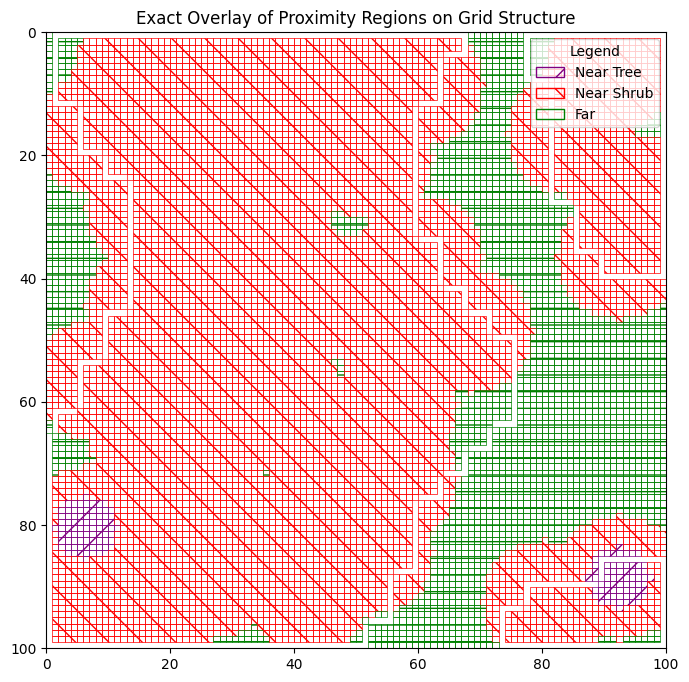

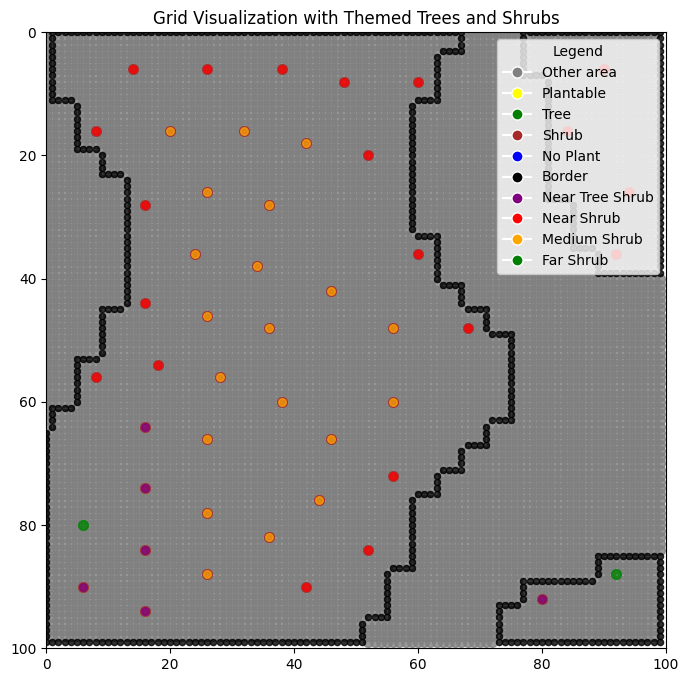

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import distance_transform_edt

def calculate_distance_maps(grid):
    tree_value = 1
    shrub_value = 2

    tree_distance_map = distance_transform_edt(grid != tree_value)
    shrub_distance_map = distance_transform_edt(grid != shrub_value)

    all_colored_elements = (grid == tree_value) | (grid == shrub_value)
    colored_distance_map = distance_transform_edt(~all_colored_elements)

    return tree_distance_map, shrub_distance_map, colored_distance_map

def calculate_distance_to_border(grid, border_value=255):
    """
    Calculate the Euclidean distance from each plot to the nearest border.

    Args:
        grid (np.ndarray): The grid with shrub placements and borders.
        border_value (int): The pixel value in the grid representing the border.

    Returns:
        distance_map (np.ndarray): The distance of each point to the nearest border.
    """
    border_mask = (grid == border_value).astype(int)
    distance_map = distance_transform_edt(1 - border_mask)  # Invert mask so distance is from border pixels
    return distance_map

def calculate_distance_to_tree(grid, tree_value=1):
    """
    Calculate the Euclidean distance from each plot to the nearest tree.

    Args:
        grid (np.ndarray): The grid with shrub placements and trees.
        tree_value (int): Value in the grid representing trees.

    Returns:
        distance_map (np.ndarray): The distance of each point to the nearest tree.
    """
    tree_mask = (grid == tree_value).astype(int)
    distance_map = distance_transform_edt(1 - tree_mask)  # Invert mask so distance is from tree pixels
    return distance_map

def create_proximity_overlay(grid, tree_distance_map, colored_distance_map, distance_threshold=10):
    proximity_grid = np.full(grid.shape, None, dtype=object)
    
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] == 255:  # Black border cells remain unmodified
                continue

            tree_dist = tree_distance_map[i, j]
            colored_dist = colored_distance_map[i, j]
            
            if tree_dist <= distance_threshold / 2:
                proximity_grid[i, j] = "Near Tree"
            elif colored_dist <= distance_threshold:
                proximity_grid[i, j] = "Near Shrub"
            else:
                proximity_grid[i, j] = "Far"
                
    return proximity_grid

def categorize_shrubs_by_distance(grid, border_distance_map, tree_distance_map, shrub_value=2, near_tree_thresh=20, near_thresh=10, far_thresh=50):
    """
    Categorize shrubs based on their distance to the nearest border or tree.

    Args:
        grid (np.ndarray): The grid with shrub placements.
        border_distance_map (np.ndarray): The distance of each point to the nearest border.
        tree_distance_map (np.ndarray): The distance of each point to the nearest tree.
        shrub_value (int): Value in the grid representing shrubs.
        near_tree_thresh (float): Threshold distance for "Near Tree" category.
        near_thresh (float): Threshold distance for "Near" category.
        far_thresh (float): Threshold distance for "Far" category.

    Returns:
        clusters (dict): Dictionary with shrub coordinates categorized by distance.
    """
    shrub_coords = np.argwhere(grid == shrub_value)
    clusters = {"Near Tree": [], "Near": [], "Medium": [], "Far": []}

    # Categorize each shrub based on distances
    for coord in shrub_coords:
        tree_distance = tree_distance_map[coord[0], coord[1]]
        border_distance = border_distance_map[coord[0], coord[1]]
        
        if tree_distance <= near_tree_thresh:
            clusters["Near Tree"].append(tuple(coord))
        elif border_distance <= near_thresh:
            clusters["Near"].append(tuple(coord))
        elif border_distance <= far_thresh:
            clusters["Medium"].append(tuple(coord))
        else:
            clusters["Far"].append(tuple(coord))

    return clusters

def visualize_exact_overlay(grid, proximity_grid):
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define hatching patterns and colors without "Medium"
    hatching_patterns = {
        "Near Tree": '/',
        "Near Shrub": '\\',
        "Far": '-'
    }
    cluster_colors = {
        "Near Tree": "purple",
        "Near Shrub": "red",
        "Far": "green"
    }

    # Plot the proximity categories on top of the exact grid layout
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            category = proximity_grid[i, j]
            if category:
                color = cluster_colors[category]
                hatch = hatching_patterns[category]
                rect = patches.Rectangle((j, i), 1, 1, linewidth=0.5, edgecolor=color, facecolor='none', hatch=hatch)
                ax.add_patch(rect)

    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()

    handles = [
        patches.Patch(facecolor='none', edgecolor=cluster_colors[category], hatch=hatching_patterns[category], 
                      label=f"{category}") for category in cluster_colors.keys()
    ]
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.title("Exact Overlay of Proximity Regions on Grid Structure")
    plt.grid(False)
    plt.show()

def visualize_grid_with_circles(grid, clusters=None):
    """
    Visualize the grid with themed markers for different areas and categories of shrubs based on distance.

    Args:
        grid (np.ndarray): The grid with various elements (shrub, tree, etc.).
        clusters (dict): Optional dictionary with shrub coordinates categorized by distance.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles based on your preferences
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},  # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},  # Plantable spots
        1: {'color': 'green', 'label': 'Tree', 'size': 50},  # Tree planted
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},  # Default Shrub color
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},  # No Plant selected
        255: {'color': 'black', 'label': 'Border', 'size': 20},  # Border area
    }

    # Plot each category based on the marker_styles dictionary
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'],
                        label=style['label'], s=style['size'], alpha=0.8)

    # If clusters are provided, override shrub colors based on distance categories
    if clusters:
        cluster_colors = {"Near Tree": "purple", "Near": "red", "Medium": "orange", "Far": "green"}
        for category, color in cluster_colors.items():
            if clusters[category]:  # Only plot if there are coordinates in the category
                y_coords, x_coords = zip(*clusters[category])
                plt.scatter(x_coords, y_coords, color=color, label=f"{category} Shrub ({len(clusters[category])})", s=30, alpha=0.7)

    # Customize the plot further
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style['color'], markersize=8, label=style['label'])
               for style in marker_styles.values()]
    for category, color in cluster_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f"{category} Shrub"))
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.title("Grid Visualization with Themed Trees and Shrubs")
    plt.grid(False)
    plt.show()

# Main execution
if __name__ == "__main__":
    final_grid = main(model_path)
    grid_copy = np.copy(final_grid)

    tree_distance_map, shrub_distance_map, colored_distance_map = calculate_distance_maps(grid_copy)

    distance_threshold = 10
    proximity_overlay = create_proximity_overlay(grid_copy, tree_distance_map, colored_distance_map, distance_threshold)

    visualize_exact_overlay(grid_copy, proximity_overlay)

    # Visualize the original grid to verify no changes
    clusters = categorize_shrubs_by_distance(final_grid, tree_distance_map, colored_distance_map)

    # Calculate distance to the nearest border
    border_distance_map = calculate_distance_to_border(final_grid)

    # Calculate distance to the nearest tree
    tree_distance_map = calculate_distance_to_tree(final_grid)
    clusters = categorize_shrubs_by_distance(final_grid, border_distance_map, tree_distance_map)
    
    visualize_grid_with_circles(final_grid, clusters)


## This is the one that works, creating distance areas by the clusters

Loaded model from ./models/31st.zip
Episode finished after 600 steps


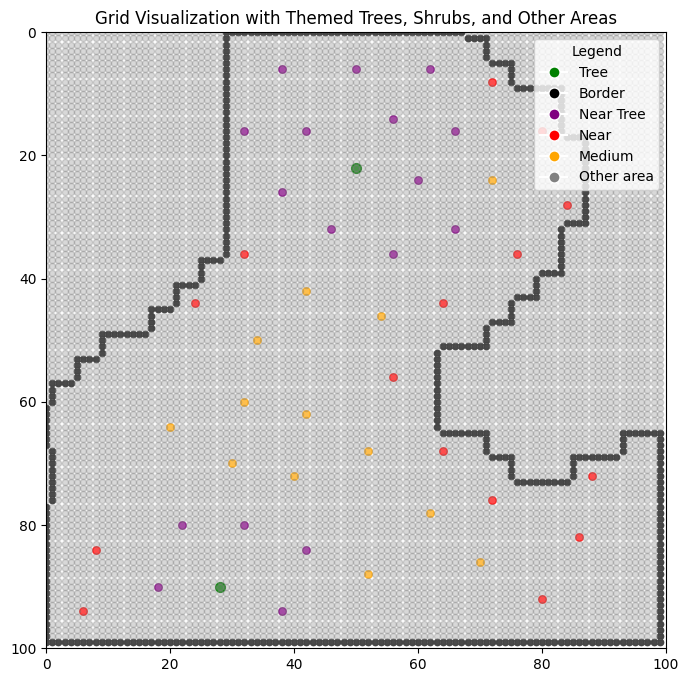

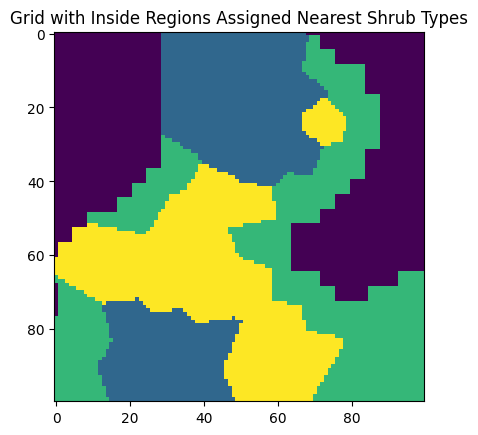

In [10]:
from scipy.ndimage import binary_fill_holes


def visualize_grid_with_circles(grid, clusters=None):
    """
    Visualize the grid with themed markers for different areas and categories of shrubs based on distance.
    Additionally, returns a formatted numpy grid with specified categories, where each category has a unique number.

    Args:
        grid (np.ndarray): The grid with various elements (shrub, tree, etc.).
        clusters (dict): Optional dictionary with shrub coordinates categorized by distance.

    Returns:
        np.ndarray: A formatted grid with unique numbers for each specified category.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define marker styles for visualization
    marker_styles = {
        1: {'color': 'green', 'label': 'Tree', 'size': 50},      # Tree planted
        255: {'color': 'black', 'label': 'Border', 'size': 20},  # Border area
    }

    # Plot each category based on the marker_styles dictionary
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'],
                        label=style['label'], s=style['size'], alpha=0.8)

    # Initialize new formatted grid with 'Other area' (0) as the default value
    formatted_grid = np.full(grid.shape, 0, dtype=int)

    # Define colors and unique numerical tags for each cluster category
    cluster_colors = {
        "Near Tree": {"color": "purple", "tag": 1},
        "Near": {"color": "red", "tag": 2},
        "Medium": {"color": "orange", "tag": 3},
        "Other area": {"color": "gray", "tag": 0}
    }

    # Override shrub colors based on distance categories and update formatted_grid with tags
    if clusters:
        for category, properties in cluster_colors.items():
            color = properties["color"]
            tag = properties["tag"]
            if category in clusters and clusters[category]:  # Only plot if there are coordinates in the category
                y_coords, x_coords = zip(*clusters[category])
                plt.scatter(x_coords, y_coords, color=color, label=f"{category} Shrub", s=30, alpha=0.7)

                # Update the formatted grid with the unique tag for each category
                for y, x in clusters[category]:
                    formatted_grid[y, x] = tag

    # Assign 'Other area' color to any remaining cells not assigned a specific category
    other_area_indices = np.argwhere(formatted_grid == 0)
    plt.scatter(other_area_indices[:, 1], other_area_indices[:, 0], color="gray", label="Other area", s=20, alpha=0.3)

    # Finalize legend and formatting
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Legend setup
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style['color'], markersize=8, label=style['label'])
               for style in marker_styles.values()]
    for category, properties in cluster_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=properties["color"], markersize=8, label=f"{category}"))
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.title("Grid Visualization with Themed Trees, Shrubs, and Other Areas")
    plt.grid(False)
    plt.show()

    return formatted_grid

def shade_inside_border(grid, border_value=255, fill_value=128):
    """
    Shade points inside the black borders on the grid with a specified fill color,
    leaving outside regions untouched.

    Args:
        grid (np.ndarray): The grid representing the environment.
        border_value (int): Value representing the border in the grid.
        fill_value (int): Value to fill the inside regions with.

    Returns:
        np.ndarray: Modified grid with inside regions shaded with the fill color.
    """
    # Create a mask for border areas
    border_mask = grid == border_value

    # Use binary_fill_holes to fill regions inside the border
    filled_region = binary_fill_holes(border_mask)

    # Create a copy of the grid to modify
    shaded_grid = np.copy(grid)
    
    # Apply the fill color to inside regions only
    shaded_grid[filled_region] = fill_value
    
    return shaded_grid



def assign_shrub_types_to_inside(shrub_position, grid_with_shades):
    """
    Create a new grid where for each cell labeled 128 in shaded_grid,
    we find the closest shrub type (1, 2, or 3) in grid_with_shades and assign
    that shrub type to the corresponding cell in the new grid, using manual distance calculations.

    Args:
        shaded_grid (np.ndarray): Grid with inside regions labeled 128.
        grid_with_shades (np.ndarray): Grid with shrubs labeled as 1, 2, or 3.

    Returns:
        np.ndarray: New grid with cells inside the border assigned the nearest shrub type.
    """

    # Ensure the grids are the same size
    assert shrub_position.shape == grid_with_shades.shape, "Grids must be the same shape."

    # Initialize a new grid with zeros
    new_grid = np.zeros_like(shrub_position, dtype=int)

    # Get the indices of inside cells (cells labeled 128)
    inside_indices = np.argwhere(grid_with_shades == 128)

    # Get the indices and types of shrubs (cells labeled 1, 2, or 3)
    shrub_indices = np.argwhere(np.isin(shrub_position, [1, 2, 3]))
    shrub_types = shrub_position[shrub_indices[:, 0], shrub_indices[:, 1]]

    # Check if there are any shrubs in the grid
    if len(shrub_indices) == 0:
        print("No shrubs found in the grid.")
        return new_grid

    # For each inside cell, find the closest shrub manually
    for y_inside, x_inside in inside_indices:
        min_distance = None
        nearest_shrub_type = 0  # Default value if no shrub is found
        for (y_shrub, x_shrub), shrub_type in zip(shrub_indices, shrub_types):
            # Calculate Euclidean distance
            distance = ((y_inside - y_shrub) ** 2 + (x_inside - x_shrub) ** 2) ** 0.5
            if (min_distance is None) or (distance < min_distance):
                min_distance = distance
                nearest_shrub_type = shrub_type
        # Assign the nearest shrub type to the new grid
        new_grid[y_inside, x_inside] = nearest_shrub_type

    return new_grid



# Main execution
if __name__ == "__main__":
    np.set_printoptions(threshold=np.inf, linewidth=np.inf)
    final_grid = main(model_path)
    grid_copy = np.copy(final_grid)

    border_distance_map = calculate_distance_to_border(final_grid)
    tree_distance_map = calculate_distance_to_tree(final_grid)
    clusters = categorize_shrubs_by_distance(final_grid, border_distance_map, tree_distance_map)
    
    shrub_position = visualize_grid_with_circles(final_grid, clusters)
    # print(grid_with_shades)  
    plt.imshow(shrub_position)

    shaded_grid = shade_inside_border(final_grid)
    # plt.imshow(shaded_grid, cmap="gray")
    # plt.title("Grid with Inside Regions Shaded")
    # plt.show()

    new_grid = assign_shrub_types_to_inside(shrub_position, shaded_grid)

    # Visualize the new grid
    plt.imshow(new_grid, cmap='viridis')
    plt.title("Grid with Inside Regions Assigned Nearest Shrub Types")
    plt.show()

## Next Step

Creating a RL model for the sake of plant selection

- Given that we will be given a unknown set of 6 plants, what is the best way to create an action space that can map to potential unknown number of plant outputs?

Model One, creating a model that is able to figure out different conditions of the exisiting areas

- Select only shrubs
- Fixed number of groups? (let's assume that the model performs the selection once per group without any repetition)

Fixed kind of values
- purple will be lower level of sun level compared to the red and orange
- Hazard tolerance will be higher for orange

Determinant values
- Maximum height
- Leaf texture
- Leaf Color



- <b>Light Preference </b>: Environment consideration, always given shade loving, if there is sun loving, sun loving should not be a certain radius within tree
- <b>Hazard </b>: if plant has hazard, should not be within certain distance from exterior
- <b>Flower Color </b>: Theme Consideration
- <b>Maximum height </b>: Shrub to fit underneath tree first, in future someone can add a height scale
- <b>Trunk Texture </b>: Theme Consideration
- <b>Trunk Color </b>: Theme Consideration
- <b>Leaf Texture </b>: Theme Consideration
- <b>Leaf Color </b>

## Basic Model 01

Trying to create a model that selects plants based on
- sun tolerance
- hazard level

In [ ]:
exampleData = {'response': '200', 'api_resp': [{'_index': 'flora', '_id': 'Ucz7y5IBzYt0LoDihG73', '_score': 4.886512, '_source': {'Scientific Name': 'Horsfieldia irya (Gaertn.) Warb.', 'Common Name': 'Pianggu', 'Species ID': 2964, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/9/2964', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': True, 'Maximum Height (m)': 30.0, 'Flower Colour': 'Orange, Yellow / Golden', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting (Fruits)', 'Native habitat': 'Terrestrial (Primary Rainforest, Coastal Forest, Riverine, Secondary Rainforest, Freshwater Swamp Forest), Shoreline (Mangrove Forest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Fissured, Cracked', 'Trunk Colour': 'red', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'U8z7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Parkia speciosa Hassk.', 'Common Name': 'Petai', 'Species ID': 3052, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/3/0/3052', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': True, 'Maximum Height (m)': 45.0, 'Flower Colour': 'Cream / Off-White, White, Yellow / Golden', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting, Butterfly Host Plant, Bat Food', 'Native habitat': 'Terrestrial (Primary Rainforest, Secondary Rainforest, Riverine)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '2.5 (Tree - Open Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'smooth', 'Trunk Colour': 'reddish-brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'WMz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Cassia grandis L. f.', 'Common Name': 'Horse Cassia', 'Species ID': 2788, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/7/2788', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 25.0, 'Flower Colour': 'Orange, Pink, Red', 'Hazard': 'N/A', 'Attracted animals': 'N/A', 'Native habitat': 'Terrestrial (Riverine)', 'Mature Leaf Colour': 'Green, Purple', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '2.5 (Tree - Open Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Smooth', 'Trunk Colour': 'Light grey', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'Wcz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Cratoxylum cochinchinense (Lour.) Blume', 'Common Name': 'Derum Selunchor', 'Species ID': 2829, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/8/2829', 'Plant Type': ['Shrub', 'Tree'], 'Light Preference': ['Full Sun', 'Semi Shade'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': True, 'Maximum Height (m)': 30.0, 'Flower Colour': 'Red, Orange, Pink', 'Hazard': 'N/A', 'Attracted animals': 'Butterfly Host Plant (Leaves, Associated with: Eurema  hecabe contubernalis (Moore, 1886), Lexias pardalis), Bee-Attracting', 'Native habitat': 'Terrestrial (Secondary Rainforest, Primary Rainforest, Freshwater Swamp Forest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'Red', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Peeling / Flaking / Papery, Smooth', 'Trunk Colour': 'Reddish-brown', 'Leaf Texture': ['Medium']}}, {'_index': 'flora', '_id': 'W8z7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Corymbia ptychocarpa (F. Muell.) K. D. Hill & L. A. S. Johnson', 'Common Name': 'Spring Bloodwood', 'Species ID': 2887, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/8/2887', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 20.0, 'Flower Colour': 'Pink, Red', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting', 'Native habitat': 'Terrestrial (Secondary Rainforest, Riverine)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Fissured', 'Trunk Colour': 'Reddish-brown to greyish-brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'XMz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Cola gigantea A.Chev.', 'Common Name': 'Giant Cola', 'Species ID': 2821, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/8/2821', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 35.0, 'Flower Colour': 'Purple', 'Hazard': 'N/A', 'Attracted animals': 'N/A', 'Native habitat': 'Terrestrial', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'brown', 'Trunk Colour': 'brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'Xcz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Erythrina fusca Lour.', 'Common Name': 'Coral Tree', 'Species ID': 2879, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/8/2879', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 15.0, 'Flower Colour': 'Orange, Red', 'Hazard': 'Spines/Thorns - Stem/Branch, Spines/Thorns - Trunk, Toxic Upon Ingestion', 'Attracted animals': 'N/A', 'Native habitat': 'Terrestrial (Coastal Forest, Riverine), Shoreline (Sandy Beach)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Peeling / Flaking / Papery', 'Trunk Colour': 'Brownish grey, brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'X8z7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Samanea saman (Jacq.) Merr.', 'Common Name': 'Rain Tree', 'Species ID': 3106, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/3/1/3106', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 30.0, 'Flower Colour': 'Pink, White', 'Hazard': 'N/A', 'Attracted animals': 'N/A', 'Native habitat': 'Terrestrial (Primary Rainforest, Grassland / Savannah/ Scrubland)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '2.5 (Tree - Open Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Fissured', 'Trunk Colour': 'Dark brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'ZMz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Xanthostemon chrysanthus (F.Muell.) Benth.', 'Common Name': 'Golden Penda', 'Species ID': 3200, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/3/2/3200', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': False, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 40.0, 'Flower Colour': 'Yellow / Golden', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting, Butterfly-Attracting, Bee-Attracting', 'Native habitat': 'Terrestrial (Primary Rainforest, Secondary Rainforest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'Red', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Scaly, Smooth', 'Trunk Colour': 'Brown', 'Leaf Texture': ['N/A']}}, {'_index': 'flora', '_id': 'Zsz7y5IBzYt0LoDihG73', '_score': 1.0320289, '_source': {'Scientific Name': 'Sterculia macrophylla Vent.', 'Common Name': 'Broad-leaved Sterculia', 'Species ID': 3138, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/3/1/3138', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': None, 'Maximum Height (m)': 40.0, 'Flower Colour': 'Yellow / Golden, Pink', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting', 'Native habitat': 'Terrestrial (Primary Rainforest, Secondary Rainforest, Freshwater Swamp Forest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'Red', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'smooth', 'Trunk Colour': 'light grey', 'Leaf Texture': ['N/A']}}]}

In [ ]:
print(exampleData)

{'response': '200', 'api_resp': [{'_index': 'flora', '_id': 'Ucz7y5IBzYt0LoDihG73', '_score': 4.886512, '_source': {'Scientific Name': 'Horsfieldia irya (Gaertn.) Warb.', 'Common Name': 'Pianggu', 'Species ID': 2964, 'Link': 'https://www.nparks.gov.sg/florafaunaweb/flora/2/9/2964', 'Plant Type': ['Tree'], 'Light Preference': ['Full Sun'], 'Water Preference': ['Lots of Water', 'Moderate Water'], 'Drought Tolerant': False, 'Native to SG': True, 'Fruit Bearing': False, 'Fragrant Plant': True, 'Maximum Height (m)': 30.0, 'Flower Colour': 'Orange, Yellow / Golden', 'Hazard': 'N/A', 'Attracted animals': 'Bird-Attracting (Fruits)', 'Native habitat': 'Terrestrial (Primary Rainforest, Coastal Forest, Riverine, Secondary Rainforest, Freshwater Swamp Forest), Shoreline (Mangrove Forest)', 'Mature Leaf Colour': 'Green', 'Young Flush Leaf Colour': 'N/A', 'Leaf Area Index': '3.0 (Tree - Intermediate Canopy)', 'Growth rate': ['Moderate'], 'Trunk Texture': 'Fissured, Cracked', 'Trunk Colour': 'red', '